In [140]:
import pandas as pd
import os
import numpy as np
import random
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime as dt
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler,LabelEncoder,OneHotEncoder,OrdinalEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import datasets

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_recall_curve, roc_auc_score, roc_curve, confusion_matrix, classification_report, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, average_precision_score

from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

SEED = 123
random.seed(SEED)
np.random.seed(SEED)

In [21]:
df = pd.read_csv('./Dataset/healthcare-dataset-stroke-data.csv')
print(df.shape)
df.head()

(5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [22]:
df = df.drop(columns=['id'])
df = df.drop_duplicates().reset_index(drop=True)
cat_cols = []
num_cols = []

for i in df.columns:
    # print(str(df[i].dtype))
    if 'int' in str(df[i].dtype) or 'float' in str(df[i].dtype):
        num_cols.append(i)
    else:
        cat_cols.append(i)

num_cols = [i for i in num_cols if i not in ['hypertension','heart_disease','stroke']]
cat_cols.extend(['hypertension','heart_disease','stroke'])

print(f'Categorical: {cat_cols}')
print(f'Numeric: {num_cols}')

Categorical: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'hypertension', 'heart_disease', 'stroke']
Numeric: ['age', 'avg_glucose_level', 'bmi']


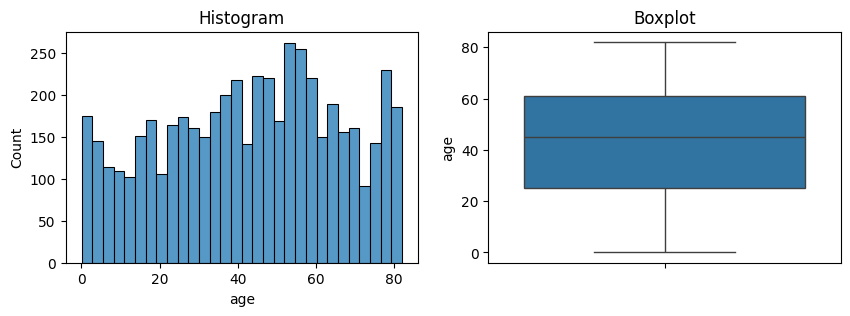

Skewness: -0.1370593225984694
Kurtosis: -0.9910102432016696


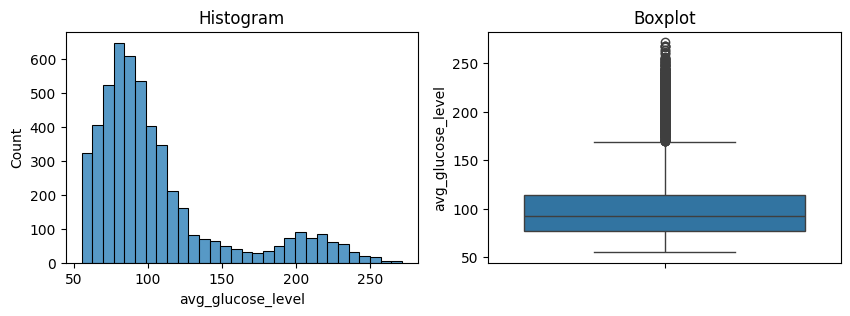

Skewness: 1.5722838665030459
Kurtosis: 1.6804785404038278


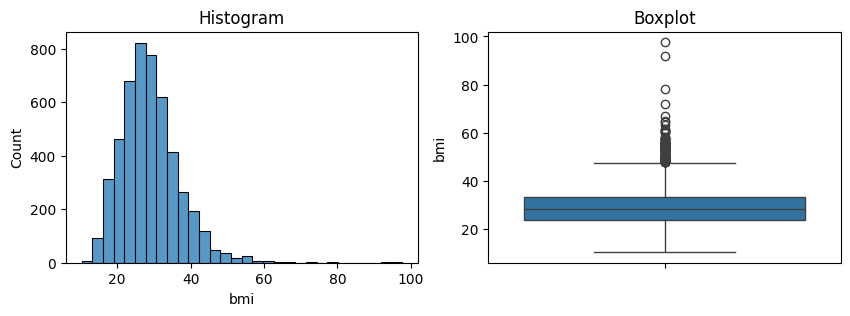

Skewness: 1.0553402052962912
Kurtosis: 3.3626591656236746


In [13]:
def check_distribution_outliers(df, columns):
    for col in columns:
        plt.figure(figsize=(10, 3))

        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], bins=30)
        plt.title('Histogram')

        # Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[col])
        plt.title('Boxplot')

        plt.show()

        print('Skewness:', df[col].skew())
        print('Kurtosis:', df[col].kurt())

check_distribution_outliers(df[num_cols], num_cols)

In [14]:
for i in df.columns:
    print(i, df[i].isna().sum())

gender 0
age 0
hypertension 0
heart_disease 0
ever_married 0
work_type 0
Residence_type 0
avg_glucose_level 0
bmi 201
smoking_status 0
stroke 0


In [53]:
df = df.dropna(subset=['bmi']).reset_index(drop=True)

In [23]:
for i in cat_cols:
    print(df[i].value_counts(),'\n')

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64 

ever_married
Yes    3353
No     1757
Name: count, dtype: int64 

work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64 

Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64 

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64 

hypertension
0    4612
1     498
Name: count, dtype: int64 

heart_disease
0    4834
1     276
Name: count, dtype: int64 

stroke
0    4861
1     249
Name: count, dtype: int64 



In [54]:
df = df[df['gender']!='Other']

In [55]:
bin_cols = ['Residence_type','ever_married','gender']

ord_enc = OrdinalEncoder(categories=[['never smoked','Unknown','formerly smoked','smokes']])
ohe_enc = OneHotEncoder(sparse_output=False)
bin_enc_dict = {}

In [56]:
oh_encoded = ohe_enc.fit_transform(pd.DataFrame(df['work_type']))
one_hot_df = pd.DataFrame(oh_encoded, columns=ohe_enc.get_feature_names_out(['work_type']))

In [57]:
data = df.copy().reset_index(drop=True)
data['smoking_status'] = ord_enc.fit_transform(df[['smoking_status']])
for i in bin_cols:
    bin_enc_dict[i] = LabelEncoder()
    data[i] = bin_enc_dict[i].fit_transform(data[i])

data = pd.concat([data.drop(columns=['work_type']),one_hot_df.astype('int')],axis=1)
data.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,1,67.0,0,1,1,1,228.69,36.6,2.0,1,0,0,1,0,0
1,1,80.0,0,1,1,0,105.92,32.5,0.0,1,0,0,1,0,0
2,0,49.0,0,0,1,1,171.23,34.4,3.0,1,0,0,1,0,0
3,0,79.0,1,0,1,0,174.12,24.0,0.0,1,0,0,0,1,0
4,1,81.0,0,0,1,1,186.21,29.0,2.0,1,0,0,1,0,0


# No Sampling

In [58]:
x = data[data.columns.drop('stroke')]
y = data['stroke']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2,random_state=123)
print(x_train.shape,x_test.shape)

(3926, 14) (982, 14)


In [59]:
rob_scaler = RobustScaler()
x_train[num_cols] = rob_scaler.fit_transform(x_train[num_cols])
x_test[num_cols] = rob_scaler.transform(x_test[num_cols])


In [63]:
model = LogisticRegression()
model.fit(x_train, y_train)

y_preds = model.predict(x_test)
y_preds_proba = model.predict_proba(x_test)

In [90]:
print(y_preds,y_preds_proba)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [67]:
print(classification_report(y_test,y_pred=y_preds))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       942
           1       0.00      0.00      0.00        40

    accuracy                           0.96       982
   macro avg       0.48      0.50      0.49       982
weighted avg       0.92      0.96      0.94       982



d:\Anaconda\envs\torch_py310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Anaconda\envs\torch_py310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Anaconda\envs\torch_py310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [84]:
cm = confusion_matrix(y_test,y_preds,labels = [0,1])
print(cm)
print(pd.DataFrame(cm))

[[942   0]
 [ 40   0]]
     0  1
0  942  0
1   40  0


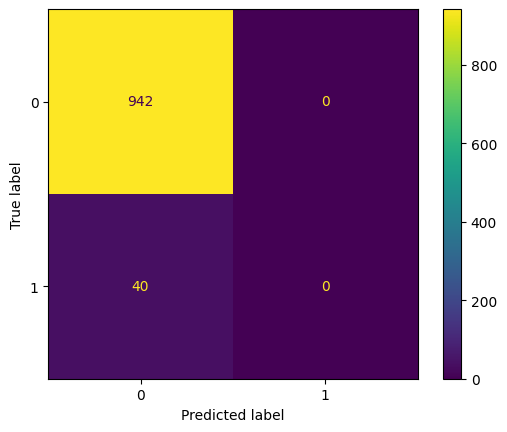

In [83]:
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
cm_plot.plot()


In [88]:
def calc_class_metrics(y_test,y_preds,y_preds_proba=None):
    res_dict = {}
    res_dict['accuracy'] = accuracy_score(y_test,y_preds)
    res_dict['recall'] = recall_score(y_test,y_preds)
    res_dict['precision'] = precision_score(y_test,y_preds)
    res_dict['f1_score'] = f1_score(y_test,y_preds)

    if len(y_preds_proba)>0:
        res_dict['auc'] = roc_auc_score(y_test,y_preds_proba)
    return pd.DataFrame([res_dict])

In [91]:
calc_class_metrics(y_test,y_preds,y_preds_proba[:, 1])

d:\Anaconda\envs\torch_py310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,accuracy,recall,precision,f1_score,auc
0,0.959267,0.0,0.0,0.0,0.853503


In [96]:
fpr, tpr, thresholds = roc_curve(y_test,y_preds_proba[:,1])
fpr, tpr, thresholds

(array([0.        , 0.        , 0.00212314, 0.00212314, 0.00636943,
        0.00636943, 0.01061571, 0.01061571, 0.01698514, 0.01698514,
        0.02123142, 0.02123142, 0.02229299, 0.02229299, 0.02441614,
        0.02441614, 0.04352442, 0.04352442, 0.04670913, 0.04670913,
        0.05201699, 0.05201699, 0.05626327, 0.05626327, 0.06157113,
        0.06157113, 0.08280255, 0.08280255, 0.09235669, 0.09235669,
        0.09660297, 0.09660297, 0.09872611, 0.09872611, 0.11677282,
        0.11677282, 0.17409766, 0.17409766, 0.18471338, 0.18471338,
        0.20169851, 0.20169851, 0.22399151, 0.22399151, 0.22717622,
        0.22717622, 0.23354565, 0.23354565, 0.33333333, 0.33333333,
        0.36518047, 0.36518047, 0.46178344, 0.46178344, 0.47239915,
        0.47239915, 0.52653928, 0.52653928, 0.52760085, 0.52760085,
        0.57643312, 0.57643312, 1.        ]),
 array([0.   , 0.025, 0.025, 0.05 , 0.05 , 0.075, 0.075, 0.15 , 0.15 ,
        0.175, 0.175, 0.2  , 0.2  , 0.25 , 0.25 , 0.275, 0.275, 0.3

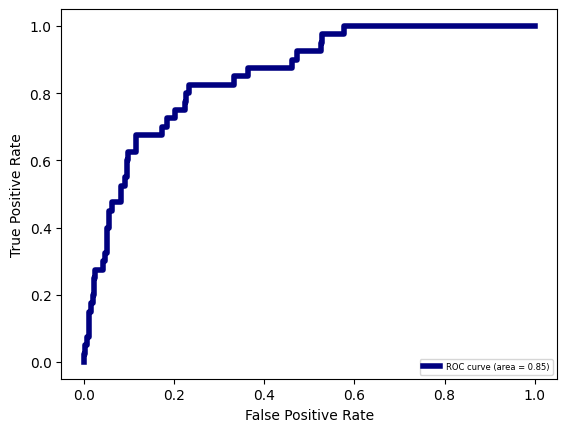

In [101]:
plt.plot(
    fpr,
    tpr,
    label="ROC curve (area = {0:0.2f})".format(roc_auc_score(y_test,y_preds_proba[:,1])),
    color="navy",
#     linestyle=":",
    linewidth=4,
)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right",prop={'size': 6})
plt.show()


In [104]:
precision, recall, thresholds = precision_recall_curve(y_test,y_preds_proba[:,1])

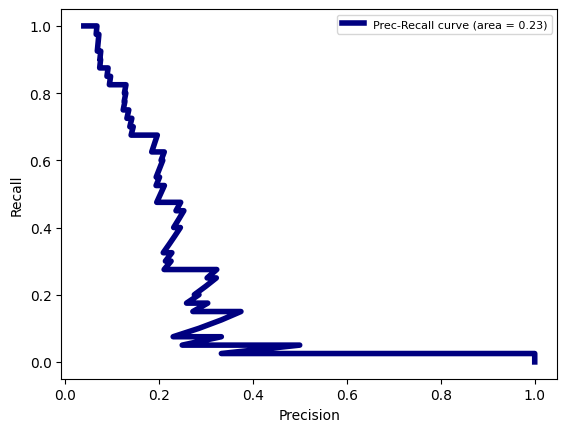

In [114]:
plt.plot(
    precision,
    recall,
    label="Prec-Recall curve (area = {0:0.2f})".format(average_precision_score(y_test,y_preds_proba[:,1])),
    color="navy",
#     linestyle=":",
    linewidth=4,
)

plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="upper right",prop={'size': 8})
plt.show()


# Random Undersampling (RUS)

In [122]:
x = data[data.columns.drop('stroke')]
y = data['stroke']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2,random_state=123)

rus = RandomUnderSampler(random_state=SEED, sampling_strategy='majority')
x_train,y_train = rus.fit_resample(x_train,y_train)

print(x_train.shape,x_test.shape)

(338, 14) (982, 14)


In [123]:
y_train.value_counts()

stroke
0    169
1    169
Name: count, dtype: int64

In [124]:
rob_scaler = RobustScaler()
x_train[num_cols] = rob_scaler.fit_transform(x_train[num_cols])
x_test[num_cols] = rob_scaler.transform(x_test[num_cols])

model = LogisticRegression()
model.fit(x_train, y_train)

y_preds = model.predict(x_test)
y_preds_proba = model.predict_proba(x_test)

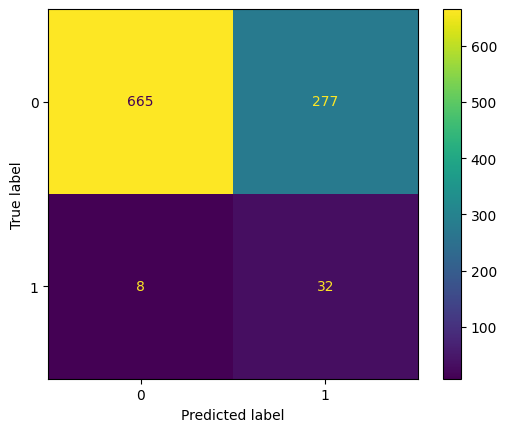

In [126]:
cm = confusion_matrix(y_test,y_preds,labels = [0,1])
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
cm_plot.plot()


In [127]:
calc_class_metrics(y_test,y_preds,y_preds_proba[:, 1])

,accuracy,recall,precision,f1_score,auc
0,0.709776,0.8,0.10356,0.183381,0.846683


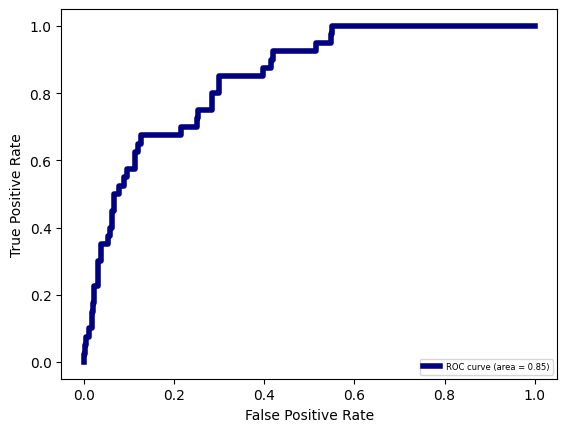

In [128]:
fpr, tpr, thresholds = roc_curve(y_test,y_preds_proba[:,1])
plt.plot(
    fpr,
    tpr,
    label="ROC curve (area = {0:0.2f})".format(roc_auc_score(y_test,y_preds_proba[:,1])),
    color="navy",
#     linestyle=":",
    linewidth=4,
)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right",prop={'size': 6})
plt.show()


# SMOTE & ROS

In [130]:
x = data[data.columns.drop('stroke')]
y = data['stroke']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2,random_state=123)

ros = RandomOverSampler(random_state=SEED, sampling_strategy='minority')
x_train,y_train = ros.fit_resample(x_train,y_train)

print(x_train.shape,x_test.shape)

(7514, 14) (982, 14)


In [132]:
y_train.value_counts()

stroke
0    3757
1    3757
Name: count, dtype: int64

In [131]:
rob_scaler = RobustScaler()
x_train[num_cols] = rob_scaler.fit_transform(x_train[num_cols])
x_test[num_cols] = rob_scaler.transform(x_test[num_cols])

model = LogisticRegression()
model.fit(x_train, y_train)

y_preds = model.predict(x_test)
y_preds_proba = model.predict_proba(x_test)

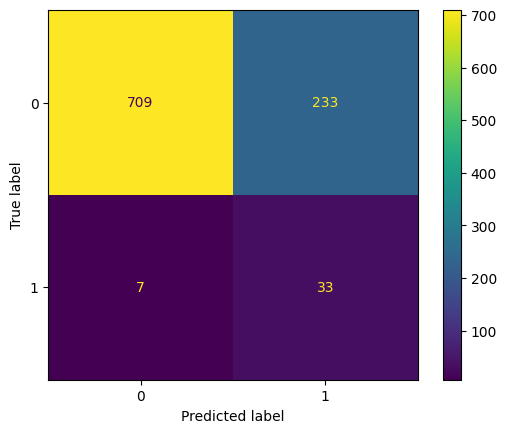

In [135]:
cm = confusion_matrix(y_test,y_preds,labels = [0,1])
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
cm_plot.plot()


In [134]:
calc_class_metrics(y_test,y_preds,y_preds_proba[:, 1])

,accuracy,recall,precision,f1_score,auc
0,0.755601,0.825,0.12406,0.215686,0.854087


In [136]:
x = data[data.columns.drop('stroke')]
y = data['stroke']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2,random_state=123)

ros = SMOTE(random_state=SEED, sampling_strategy='minority')
x_train,y_train = ros.fit_resample(x_train,y_train)

print(x_train.shape,x_test.shape)

(7514, 14) (982, 14)


In [137]:
rob_scaler = RobustScaler()
x_train[num_cols] = rob_scaler.fit_transform(x_train[num_cols])
x_test[num_cols] = rob_scaler.transform(x_test[num_cols])

model = LogisticRegression()
model.fit(x_train, y_train)

y_preds = model.predict(x_test)
y_preds_proba = model.predict_proba(x_test)

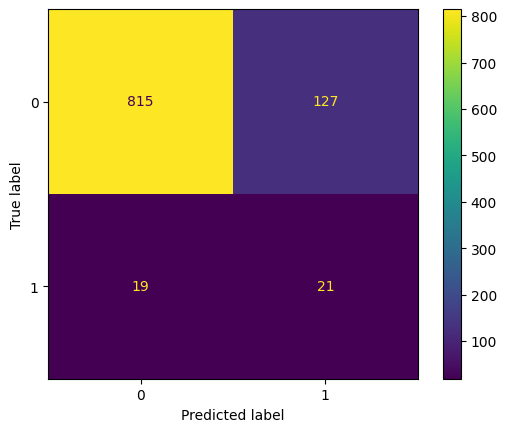

In [138]:
cm = confusion_matrix(y_test,y_preds,labels = [0,1])
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
cm_plot.plot()


In [139]:
calc_class_metrics(y_test,y_preds,y_preds_proba[:, 1])

,accuracy,recall,precision,f1_score,auc
0,0.851324,0.525,0.141892,0.223404,0.824337


# Class Weighting

In [146]:
x = data[data.columns.drop('stroke')]
y = data['stroke']
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2,random_state=123)

print(x_train.shape,x_test.shape)
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights

(3926, 14) (982, 14)


array([ 0.52249135, 11.61538462])

In [145]:
cw_dict = {0:class_weights[0],1:class_weights[1]}
cw_dict

{0: 0.5224913494809689, 1: 11.615384615384615}

In [147]:
rob_scaler = RobustScaler()
x_train[num_cols] = rob_scaler.fit_transform(x_train[num_cols])
x_test[num_cols] = rob_scaler.transform(x_test[num_cols])

model = LogisticRegression(class_weight=cw_dict)
model.fit(x_train, y_train)

y_preds = model.predict(x_test)
y_preds_proba = model.predict_proba(x_test)

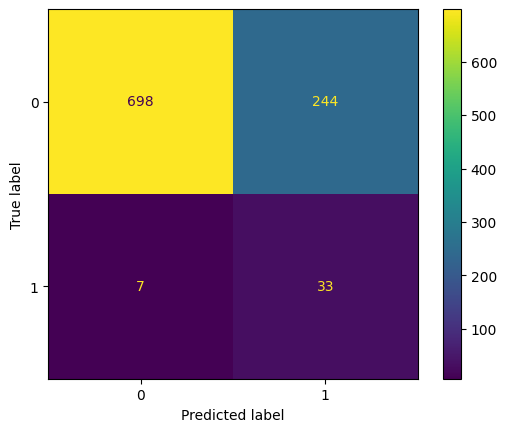

In [149]:
cm = confusion_matrix(y_test,y_preds,labels = [0,1])
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
cm_plot.plot()


In [148]:
calc_class_metrics(y_test,y_preds,y_preds_proba[:, 1])

,accuracy,recall,precision,f1_score,auc
0,0.744399,0.825,0.119134,0.208202,0.853025
